In [1]:
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from matplotlib import pyplot as plt
from scipy.stats.kde import gaussian_kde


/home/sudarshan/Documents/TDL/TDL2022/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
means = 3
sigma1 = 1

NumMeans = 10 
Mean = np.random.normal(means, sigma1, NumMeans ) 
x = np.arange(-2, 10, 0.024)
kde = gaussian_kde( Mean )
dist_space = np.linspace( min(Mean), max(Mean), 100 )

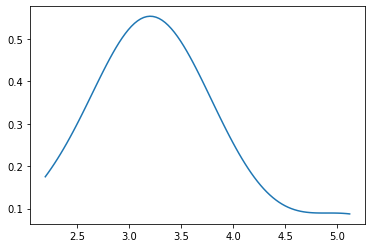

In [3]:
plt.plot( dist_space, kde(dist_space) )
plt.show()

In [4]:
numFeaturePts = 20
Data1 = []
y =[]
for i in range( NumMeans ):
    dist1 = np.array(  np.random.normal( Mean[i], sigma1, numFeaturePts ) ,  dtype=np.float32) 
    Data1.append(dist1)
    if(Mean[i] < 2.5 ):
        y.append(1)
    else:
        y.append(0)
    

for i in range( 0 , NumMeans, 2 ):
    
    if( y[i]+y[i+1] >= 1 ):
        y.append( 1 )
        if( y[i] == 1 ):
            Data1.append( Data1[i] )
        else:
            Data1.append( Data1[i+1] )
    else:
        y.append(0)
        Data1.append( Data1[i] )
        
    

y.append(1)
y.append(1)
Data1.append( Data1[11] )
Data1.append( Data1[14] )

    
Data1 = torch.tensor(Data1 , device='cpu' , dtype=torch.float32)

y = torch.tensor( y, device='cpu' , dtype=torch.long  )




/tmp/ipykernel_36734/870543743.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  Data1 = torch.tensor(Data1 , device='cpu' , dtype=torch.float32)


In [5]:
edge_index = torch.tensor([[0, 10],
                           [10, 0],

                           [1, 10],
                           [10, 1] ,

                           [2 , 11] , 
                           [11, 2] , 

                           [3 , 11] , 
                           [11 , 3] , 

                           [4 , 12] , 
                           [12 , 4] ,

                           [5,12],
                           [12,5],

                           [6,13],
                           [13,6],

                           [7 , 13],
                           [13 , 7],

                           [8,14],
                           [14,8],

                           [9 ,14],
                           [14,8],

                           [10,15],
                           [15,10],

                           [15,11],
                           [11,15],

                           [12,16],
                           [16,12],

                           [13,16],
                           [16,13],

                           [14,16],
                           [16,14]

                            ] , dtype=torch.long)


edge_index = torch.transpose( edge_index ,  0 , 1)

In [6]:
train_mask = torch.tensor( [ True, True , True, False,True,True,True,True,True,False,False,False,False,False,False,False,False])

data = Data(x=Data1, edge_index=edge_index , y=y , train_mask=train_mask , val_mask= train_mask, test_mask=train_mask)


In [7]:
print( data)

Data(x=[17, 20], edge_index=[2, 30], y=[17], train_mask=[17], val_mask=[17], test_mask=[17])


In [8]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(20, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [9]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GCN().to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(50):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

cpu


In [10]:
model.eval()
pred = model(data).argmax(dim=1)
print(pred)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
print(correct)

acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(7)
Accuracy: 0.8750


In [11]:
print(y)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1])


In [12]:
torch.save(model.state_dict(), 'collision_model_weights.pth')